Download the script provided by the course that lets us download the dataset

In [ ]:
!pip install wget
!wget https://gist.github.com/pbloem/2c3af77626d6c80f62487c35a28e3e8c/raw/5730d8f548a55a98b4415a457c5d827b33cd64d3/data_rnn.py

--2021-12-07 20:29:09--  https://gist.github.com/pbloem/2c3af77626d6c80f62487c35a28e3e8c/raw/5730d8f548a55a98b4415a457c5d827b33cd64d3/data_rnn.py
Resolving gist.github.com (gist.github.com)... 13.114.40.48
Connecting to gist.github.com (gist.github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://gist.githubusercontent.com/pbloem/2c3af77626d6c80f62487c35a28e3e8c/raw/5730d8f548a55a98b4415a457c5d827b33cd64d3/data_rnn.py [following]
--2021-12-07 20:29:09--  https://gist.githubusercontent.com/pbloem/2c3af77626d6c80f62487c35a28e3e8c/raw/5730d8f548a55a98b4415a457c5d827b33cd64d3/data_rnn.py
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4074 (4.0K) [text/plain]
Saving to: ‘data_rnn.py.2’

data

Import required libraries


In [ ]:
# %%
from data_rnn import load_imdb
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

Load our dataset

In [ ]:
(x_train, y_train), (x_val, y_val), (i2w, w2i), numcls = load_imdb(final=True)
print(len(x_train), len(x_val))


25000 25000


Figuring out some of the information about our dataset

Biggest training sample: 2514 words


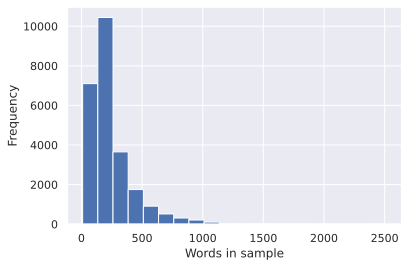

Index of .pad token: 0


In [ ]:
# Find biggest sample
max_size = len(max(x_train, key = lambda sample : len(sample)))
print(f"Biggest training sample: {max_size} words")

# Hist of sample length distribution
plt.hist([len(sample) for sample in x_train], bins=20)
plt.xlabel("Words in sample")
plt.ylabel("Frequency")
plt.show()

# %%
# Get index of pad token
pad_index = i2w.index(".pad")
print(f"Index of .pad token: {pad_index}")

We need to create batches of tensor which all have the same size (per tensor, not all tensors need to have the same size) and add padding.

In [ ]:
# Function which both creates batches of similair sized sentences and -
# truncates or pads samples to standard size
def batch_pad_and_truncate(x, y, batch_size, pad_index):
    m = len(x)

    # Sorted x and y using len of x
    # Because we sort, more similairly sized samples are together, thus less padding, thus smaller dataset.
    sorted_x = [x for (x,y) in sorted(zip(x, y), key = lambda pair: len(pair[0]))]
    sorted_y = [y for (x,y) in sorted(zip(x, y), key = lambda pair: len(pair[0]))]
    x_batches, y_batches = [], []

    for batch_i in range(int(np.ceil(m/batch_size))):
        batch_begin, batch_end = batch_i * batch_size, (batch_i+1) * batch_size
        batch_end = -1 if batch_end > m else batch_end

        # Longest sample occuring in batch
        max_batch_size = len(max(sorted_x[batch_begin:batch_end], key = lambda x: len(x)))
        
        # Create padded batches
        x_batch = [sample + [pad_index]*(max_batch_size-len(sample)) for sample in sorted_x[batch_begin:batch_end]]
        y_batch = sorted_y[batch_begin:batch_end]

        x_batches.append(torch.tensor(x_batch, dtype=torch.long))
        y_batches.append(torch.tensor(y_batch, dtype=torch.long))
    return x_batches, y_batches

Apply the function to our train and test set

In [ ]:
batch_size = 128
x_train_padded, y_train_padded = batch_pad_and_truncate(x_train, y_train, batch_size, pad_index)
x_val_padded, y_val_padded = batch_pad_and_truncate(x_val, y_val, batch_size, pad_index)

Now lets define all our models

In [ ]:
class BaselineNet(nn.Module):
    """The baseline model, which does not use the sequence order at all"""
    def __init__(self):
        super().__init__()
        
        self.name = "BaselineNet"
        self.embedding = nn.Embedding(len(i2w), 300)
        self.linear1 = nn.Linear(300, 300)
        self.linear2 = nn.Linear(300, numcls)


    def forward(self, x):
        x = self.embedding(x)
        x = F.relu(self.linear1(x))
        x, inds = torch.max(x,dim=1)
        x = self.linear2(x)
        return x


class OwnElmanNet(nn.Module):
    """The ElmanNet we implemented ourselved"""
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(len(i2w), 300)
        self.linear2 = nn.Linear(300, numcls)
        self.elman= ElmanLayer()



    def forward(self, x):
        x = self.embedding(x)
        x, hidden = self.elman(x)
        x = F.relu(x)
        x, inds = torch.max(x,dim=1)
        x = self.linear2(x)
        return x


class ElmanLayer(nn.Module):
    """A single Elam layer, consists of two linear layers, the first of which we concantenate the hidden layer of t-1 to"""
    def __init__(self, insize=300, outsize=300, hsize=300):
        super().__init__()
        self.lin1 = nn.Linear(2 * insize, hsize)
        self.lin2 = nn.Linear(hsize, outsize)

    def forward(self, x, hidden=None):
        b, t, e = x.size()

        if hidden is None:
            hidden = torch.zeros(b, e, dtype=torch.float).to(device)

        outs = []
        for i in range(t):
            inp = torch.cat([x[:, i, :], hidden], dim=1)
            hidden = F.tanh(self.lin1(inp))
            out = self.lin2(hidden)
            outs.append(out[:, None, :])
        return torch.cat(outs, dim=1), hidden


class TorchElmanNet(nn.Module):
    """ElmanNet implemented using the Elman layer of pytorch"""
    def __init__(self):
        super().__init__()

        self.name = "TorcElmanNet"
        self.embedding = nn.Embedding(len(i2w), 300)

        self.rnn= nn.RNN(300,300,num_layers=1, batch_first=True)
        self.linear1 = nn.Linear(300, 300)
        self.linear2 = nn.Linear(300, numcls)
        

    def forward(self, x):
        x = self.embedding(x)
        x, hidden = self.rnn(x)
        x = F.relu(self.linear1(x))
        x, inds = torch.max(x,dim=1)
        x = self.linear2(x)
        return x


class TorchLSTM(nn.Module):
    """ElmanNet implemented using the LSTM layer of pytorch"""
    def __init__(self):
        super().__init__()

        self.name = "TorchLSTM"
        self.embedding = nn.Embedding(len(i2w), 300)

        self.rnn= nn.LSTM(300,300,num_layers=1, batch_first=True)
        self.linear1 = nn.Linear(300, 300)
        self.linear2 = nn.Linear(300, numcls)
        

    def forward(self, x):
        x = self.embedding(x)
        x, hidden = self.rnn(x)
        x = F.relu(self.linear1(x))
        x, inds = torch.max(x,dim=1)
        x = self.linear2(x)
        return x

The training loop

In [ ]:
def test_network_hyperparameters(learning_rate, network):

    train_loss, val_loss = [], []
    train_steps, val_steps = [], []
    epochs_to_print_acc = [0,1,2,3,4]
    epochs = 5
    gpu_mode = True
    net = network()
    print(f"Testing {net.__class__.__name__}, learning rate = {learning_rate}")
    criterion = nn.functional.cross_entropy
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    if gpu_mode:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device("cpu")

    print(f"Model is running on {device}")
    net.to(device)
    t0 = time.time()
    acc_list = []
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, (x_data, y_data) in enumerate(zip(x_train_padded, y_train_padded)):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = x_data.to(device), y_data.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 30 == 29:    # print every 100 mini-batches
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss/30))
                train_loss.append(running_loss/30)
                train_steps.append((epoch*len(x_train_padded)) + i)
                running_loss = 0.0
                correct = 0
        if epoch in epochs_to_print_acc: 
            ####### Calculate validation accuracy
            correct = 0
            total = 0
            # since we're not training, we don't need to calculate the gradients for our outputs
            with torch.no_grad():
                val_losses = []
                for i, (x_data, y_data) in enumerate(zip(x_val_padded, y_val_padded)):
                    images, labels = x_data.to(device), y_data.to(device)
                    # calculate outputs by running images through the network
                    outputs = net(images)
                    loss = criterion(outputs, labels)
                    val_losses.append(loss.item())
                    # the class with the highest energy is what we choose as prediction
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_loss.append(np.mean(val_losses))
            val_steps.append((epoch+1)*len(x_train_padded))
                    

            print('Epoch {} Accuracy :{:.2f}'.format(epoch,(100 * correct / total) ))
            acc_list.append(100 * correct / total)
      
    t1 = time.time()
    print(acc_list)
    print(f"Total time taken: {t1 - t0}")

        
    print('Finished Training')

    return train_loss, val_loss, train_steps, val_steps


In [ ]:
device = torch.device("cuda:0")
for network in [TorchElmanNet]:
    for learning_rate in [0.01]:
        train_loss, val_loss, train_steps, val_steps = test_network_hyperparameters(learning_rate, network)

Testing TorchElmanNet, learning rate = 0.01
Model is running on cuda:0
[1,    30] loss: 0.708
[1,    60] loss: 0.646
[1,    90] loss: 0.783
[1,   120] loss: 0.616
[1,   150] loss: 0.464
[1,   180] loss: 0.475
[2,    30] loss: 0.353
[2,    60] loss: 0.299
[2,    90] loss: 0.372
[2,   120] loss: 0.484
[2,   150] loss: 0.376
[2,   180] loss: 0.342
[3,    30] loss: 0.262
[3,    60] loss: 0.226
[3,    90] loss: 0.263
[3,   120] loss: 0.432
[3,   150] loss: 0.338
[3,   180] loss: 0.307
[4,    30] loss: 0.229
[4,    60] loss: 0.181
[4,    90] loss: 0.201
[4,   120] loss: 0.420
[4,   150] loss: 0.343
[4,   180] loss: 0.217
[5,    30] loss: 0.185
[5,    60] loss: 0.143
[5,    90] loss: 0.146
[5,   120] loss: 0.415
[5,   150] loss: 0.364
[5,   180] loss: 0.185
[6,    30] loss: 0.143
[6,    60] loss: 0.126
[6,    90] loss: 0.112
[6,   120] loss: 0.422
[6,   150] loss: 0.414
[6,   180] loss: 0.263
[7,    30] loss: 0.153
[7,    60] loss: 0.137
[7,    90] loss: 0.105
[7,   120] loss: 0.362
[7,   150

In [ ]:
import seaborn as sns
sns.set()

def plot_graph(val_acc):
    plt.plot([int(i+1) for i in range(len(val_acc))],val_acc)
    plt.title(f"Elman model: validation Accuracy")
    plt.ylabel("Validation Accuracy")
    plt.xlabel("Epoch")
    plt.show()

def validation_curve(train, train_steps, val, val_steps):
    plt.plot(train_steps, train, 'b-', label="Training loss")
    plt.plot(val_steps, val, 'r-', label="Validation loss")

    plt.xlabel("Batch #")
    plt.ylabel("Loss")
    plt.title("Training & Validation loss curve")
    plt.legend()
    plt.show()

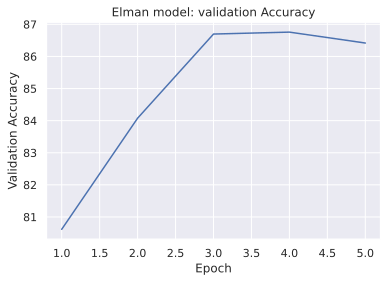

NameError: ignored

In [ ]:
val_acc = [80.61612322464492, 84.07681536307261, 86.69733946789358, 86.75735147029405, 86.41728345669134]
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'
plot_graph(val_acc)
validation_curve(train_loss, train_steps, val_loss, val_steps)